Importamos todas las librerías necesarias para realizar la regresión logística

In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

### Atributos categóricos:

El dataframe original tiene muchas columnas categóricas, les aplicaremos un OneHotEncoder para pasarlas a numéricas

In [168]:
# Cargar el dataset
dataset = pd.read_csv('student-mat.csv', delimiter=';')

# Función para aplicar el OneHotEncoder
def encoder(columna, df):
    encoder = OneHotEncoder()

    colegios_valores_encoded = encoder.fit_transform(df[[columna]])
    colegios_columnas_encoded = encoder.get_feature_names_out([columna])
    encoded_df = pd.DataFrame(colegios_valores_encoded.toarray(), columns=colegios_columnas_encoded)

    df = pd.concat([df, encoded_df], axis=1)
    df = df.drop(columns=[columna])
    return df

Podemos ver las columnas que son de tipo objeto (Strings)

In [169]:
# Vemos las columnas categóricas
columnas_obj = []

for columna in dataset.columns:
    if dataset[columna].dtype == object:
        columnas_obj.append(columna)

print(columnas_obj)

['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


Aplicamos la función a todas las columnas categóricas

In [170]:
# Les aplicamos la función a cada columna categórica
for columna in columnas_obj:
    dataset = encoder(columna, dataset)

Generamos la columna "Aprobado" a partir de las notas en G3, de 0 a 9.99, significará que está suspenso y se añadirá un 0 a la columna, de 10 en adelante significará que ha aprobado y se le añadirá un 1.

In [171]:
dataset['Aprobado'] = (dataset['G3'] >= 10).astype(int)

G3_column = dataset['G3']
dataset = dataset.drop(columns=['G3'])

Seleccionamos las columnas más relevantes con las que vamos a realizar el modelo y dividimos el dataset entre Entrenamiento y Prueba.

In [172]:
# Seleccionar las columnas para el modelo de regresión logística: horas de estudio, edad, faltas, repeticiones, nota 1º, 2º evaluación
X = dataset[['studytime', 'age', 'absences', 'failures', 'goout', 'G1', 'G2']]
Y = dataset['Aprobado']

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

Escalamos los datos.

In [173]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Entrenamos el modelo de regresión logística y vemos la matriz de confusión y la curva ROC.

Accuracy: 89.87%

Matriz de Confusión:
[[24  3]
 [ 5 47]]


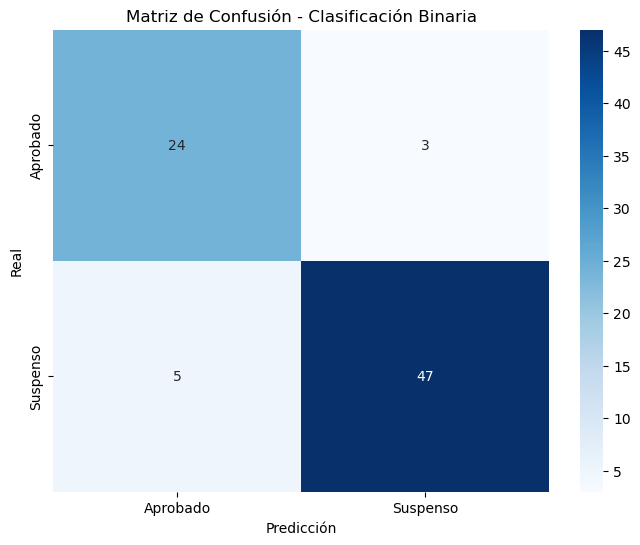

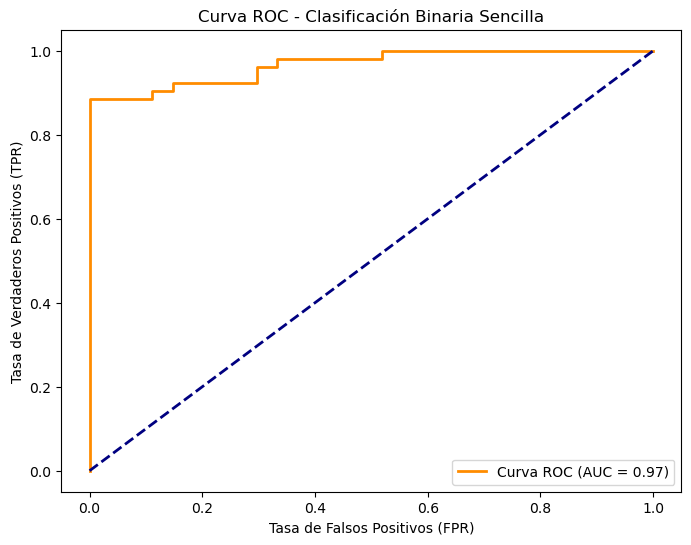

AUC: 0.97


In [174]:
# Crear el modelo de Regresión Logística
log_reg = LogisticRegression(max_iter=10000)

# Entrenar el modelo con el conjunto de entrenamiento
log_reg.fit(X_train, Y_train)

# Realizar predicciones con el conjunto de prueba
Y_pred = log_reg.predict(X_test)

# Calcular Accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Obtener la matriz de confusión
cm = confusion_matrix(Y_test, Y_pred)
print("\nMatriz de Confusión:")
print(cm)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Aprobado", "Suspenso"], yticklabels=["Aprobado", "Suspenso"])
plt.title('Matriz de Confusión - Clasificación Binaria')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Realizar predicciones con el conjunto de prueba (probabilidades) para ROC
Y_pred_prob = log_reg.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva (1)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)

# Calcular el AUC (Área Bajo la Curva)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea aleatoria (AUC = 0.5)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Clasificación Binaria Sencilla')
plt.legend(loc='lower right')
plt.show()

print(f'AUC: {roc_auc:.2f}')

Entrenamos el modelo de regresión logística con SGD y vemos la matriz de confusión y la curva ROC.

Accuracy: 92.41%

Matriz de Confusión:
[[26  1]
 [ 5 47]]


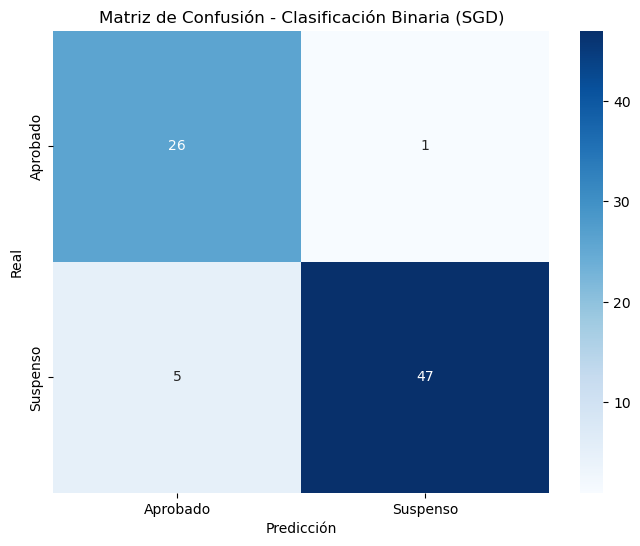

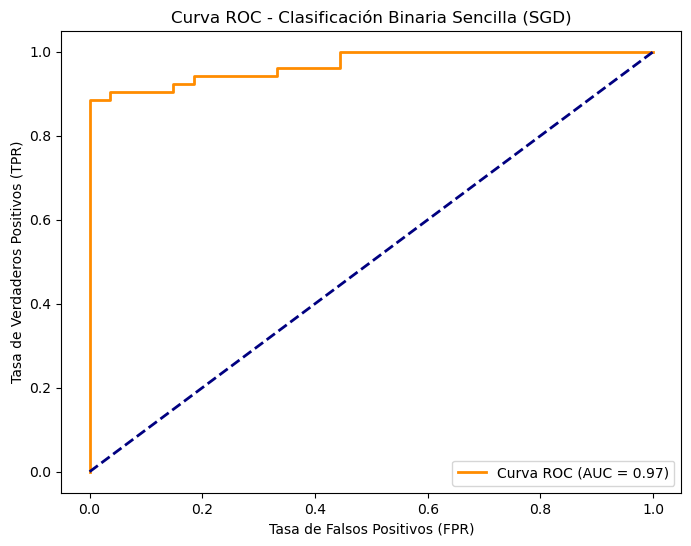

AUC: 0.97


In [175]:
# Crear el modelo de Regresión Logística con SGD, aplicamos un random_state concreto para que no varíen entre ejecuciones
sgd_log_reg = SGDClassifier(
    loss='log_loss', max_iter=1000000, tol=0.0001, random_state=8)

# Entrenar el modelo con el conjunto de entrenamiento
sgd_log_reg.fit(X_train, Y_train)

# Realizar predicciones con el conjunto de prueba
Y_pred = sgd_log_reg.predict(X_test)

# Calcular Accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Obtener la matriz de confusión
cm = confusion_matrix(Y_test, Y_pred)
print("\nMatriz de Confusión:")
print(cm)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[
            "Aprobado", "Suspenso"], yticklabels=["Aprobado", "Suspenso"])
plt.title('Matriz de Confusión - Clasificación Binaria (SGD)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Realizar predicciones con el conjunto de prueba (probabilidades) para ROC
# Probabilidades de la clase positiva (1)
Y_pred_prob = sgd_log_reg.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)

# Calcular el AUC (Área Bajo la Curva)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'Curva ROC (AUC = {roc_auc:.2f})')
# Línea aleatoria (AUC = 0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Clasificación Binaria Sencilla (SGD)')
plt.legend(loc='lower right')
plt.show()

print(f'AUC: {roc_auc:.2f}')

Hacemos 5 folds y vemos sus precisiones sin SGD

Scores en cada fold: [0.86075949 0.93670886 0.94936709 0.88607595 0.93670886]
Accuracy promedio: 0.91
Desviación estándar: 0.03


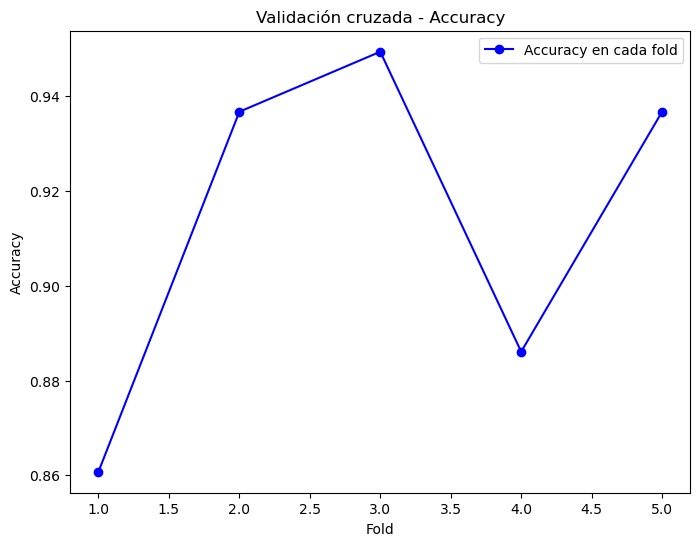

In [176]:
# Realizar la validación cruzada
scores = cross_val_score(log_reg, X, Y, cv=5)

print(f'Scores en cada fold: {scores}')
print(f'Accuracy promedio: {scores.mean():.2f}')
print(f'Desviación estándar: {scores.std():.2f}')

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(scores) + 1), scores, marker='o', color='b', label='Accuracy en cada fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Validación cruzada - Accuracy')
plt.legend()
plt.show()

Hacemos 5 folds y vemos sus precisiones con SGD

In [ ]:
# Realizar la validación cruzada
scores = cross_val_score(sgd_log_reg, X, Y, cv=5)

print(f'Scores en cada fold: {scores}')
print(f'Accuracy promedio: {scores.mean():.2f}')
print(f'Desviación estándar: {scores.std():.2f}')

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(scores) + 1), scores, marker='o', color='b', label='Accuracy en cada fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Validación cruzada - Accuracy')
plt.legend()
plt.show()

Hacemos una predicción y vemos que aprueba:

In [177]:
if log_reg.predict([[1, 15, 1, 1, 1, 12, 14]]) == 1:
    print('Aprobado')
else:
    print('Suspenso')

Aprobado


## Problemas encontrados

    En clasificación:

    Escalado de datos no se debe aplicar a G3.

    Solución: Generar la nueva columna de aprobados.

    Matriz de confusión.

    
    En regresión lineal:

    Al hacer el OneHotEncoder se generaban muchas columnas y salían demasiadas en la matriz de correlación
    
    Solución: Hacer la correlación de las características solo con G3